In [82]:
library(rhdf5)
library(MASS)
library(BoutrosLab.plotting.general)

Loading required package: lattice

Loading required package: latticeExtra

Loading required package: cluster

Loading required package: hexbin

Loading required package: grid


Attaching package: ‘BoutrosLab.plotting.general’


The following object is masked from ‘package:stats’:

    dist




# Test reading h5 and accessing data

In [3]:
fh <- "/iblm/netapp/home/karthik/crisprQTL/simulated_data/sim.h5"

Get internal structure of h5 file

In [11]:
h5ls(fh)

,group,name,otype,dclass,dim
,<chr>,<chr>,<chr>,<chr>,<chr>
0,/,coeffs,H5I_DATASET,COMPOUND,13000
1,/,counts,H5I_DATASET,INTEGER,13000 x 50000
2,/,guides,H5I_GROUP,,
3,/guides,metadata,H5I_DATASET,COMPOUND,2000
4,/guides,one_hot,H5I_DATASET,INTEGER,50000 x 2000
5,/,linear_predictor,H5I_DATASET,FLOAT,13000 x 50000
6,/,mu,H5I_DATASET,FLOAT,13000 x 50000
7,/,scaling_factors,H5I_DATASET,FLOAT,50000
8,/,x,H5I_GROUP,,


In [21]:
# read in mu values
mu.values <- h5read(file = fh, name = 'mu')

In [37]:
max(mu.values[11331, ])

ERROR: Error in mu.values[11331, "linear_predictor"]: no 'dimnames' attribute for array


In [38]:
beta1.values <- h5read(file = fh, name = 'linear_predictor')

In [47]:
which(beta1.values[11331, ] == max(beta1.values[11331, ]))

[1] 38609

In [41]:
coeffs[11331, ]

,baselines,beta1,beta2,beta3,beta4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11331,1.408948,-2.852283,1.852508,6.949296,5.034739


In [48]:
cell.cycle.scores[38609, ]

,s.scores,g2m.scores
,<dbl>,<dbl>
38609,-2.823965,4.064184


In [49]:
scaling.factors[38609]

[1] 0.049655

# Load fixed values

Coefficients (ground truth for evaluating model performance) 

Cell cycle scores (same for every gene)

In [4]:
coeffs <- h5read(file = fh, name = "coeffs")
cell.cycle.scores <- h5read(fh, "x/cell_cycle_scores")
scaling.factors <- h5read(file = fh, name = "scaling_factors")
guides.metadata <- h5read(file = fh, name = "guides/metadata")

In [5]:
head(guides.metadata)

,target.gene,efficiency,effect.size
,<int>,<dbl>,<dbl>
1,3683,0.7247283,-4.462767
2,1175,0.6302226,-4.838250
3,11331,0.5332885,-2.852283
4,1399,0.6552179,-2.778439
5,543,0.6759810,-3.910947
6,10902,0.5953462,-2.812525


# Define null and alternative models

## Model
$$y = \text{NB}(\mu=s \cdot \exp \left( \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 \right), n=\sigma)$$
### $H_0: \beta_1 = 0 $
### $H_A: \beta_1 \neq 0 $



### Test for one gene with `glm.nb` (MASS library)

In [14]:
test.gene <- 3683

obs.counts <- h5read(file = fh, name = "counts", index = list(test.gene, 1:50000))
gene.data <- data.frame(guide.eff = as.integer(h5read(file = fh, name = "x/x1", index = list(test.gene, 1:50000))),
                       s.score = cell.cycle.scores$s.scores,
                       g2m.score = cell.cycle.scores$g2m.scores,
                       counts = as.integer(obs.counts),
                       scaling.factor = scaling.factors)

In [15]:
head(gene.data)

,guide.eff,s.score,g2m.score,counts,scaling.factor
,<int>,<dbl>,<dbl>,<int>,<dbl>
1,0,-1.0309103,1.1526160,0,0.050330
2,0,-0.4639413,1.2934445,1,0.050077
3,0,0.5149060,-0.4730435,0,0.049864
4,0,-0.9497266,0.3118649,0,0.050117
5,0,1.2838343,-2.2465534,0,0.050016
6,0,-0.7403177,0.4665516,0,0.049508


In [16]:
unique(gene.data$guide.eff)

[1] 0 1

In [17]:
ml <- glm.nb(counts ~ guide.eff + s.score + g2m.score + offset(log(scaling.factor)), data = gene.data)

In [18]:
summary(ml)


Call:
glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + offset(log(scaling.factor)), 
    data = gene.data, init.theta = 1.513933735, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8242  -0.5363  -0.1985  -0.0394   4.1341  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.85635    0.01464   58.49   <2e-16 ***
guide.eff   -4.16329    0.27430  -15.18   <2e-16 ***
s.score      5.30530    0.01828  290.18   <2e-16 ***
g2m.score    3.21472    0.01469  218.83   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.5139) family taken to be 1)

    Null deviance: 493207  on 49999  degrees of freedom
Residual deviance:  27100  on 49996  degrees of freedom
AIC: 105755

Number of Fisher Scoring iterations: 1


              Theta:  1.5139 
          Std. Err.:  0.0237 

 2 x log-likelihood:  -105744.9340 

In [19]:
coeffs[test.gene,]

,baselines,beta1,beta2,beta3,beta4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3683,0.780297,-4.462767,5.321519,3.227325,1.829826


# Test for all target genes

E.g. the 1000 genes in our simulated data whose enhancers are targeted by gRNAs in our library 

In [60]:
counts.matrix <- h5read(file = fh, name = "counts")

In [61]:
head(counts.matrix)

0,1,1,0,11,0,0,0,0,0,⋯,8058,1,1,0,0,1,6,0,1,0
7097,58161,300,276,3,598,749,14586,1039,1686,⋯,2829,2612,411,4337,148,2257,100,5542,6,8030
0,1,1,0,0,0,0,0,0,0,⋯,257,2,0,1,0,0,10,0,0,3
1,9,0,0,0,0,4,5,0,0,⋯,1,3,0,23,0,0,2,1,0,0
0,3,0,0,0,0,0,0,1,0,⋯,7,1,0,0,0,0,2,0,0,1
0,2,1,0,1,1,1,0,0,2,⋯,627,3,0,0,0,0,21,0,0,2


In [140]:
scaling.factors <- colSums(counts.matrix) / sum(colSums(counts.matrix)) / 1000

In [132]:
scaling.factors

[1] 4.305211e-10 3.648022e-09 5.457570e-11 9.479162e-12 1.034827e-10
    [6] 2.332132e-11 2.350229e-10 1.465676e-08 2.718122e-11 4.162049e-11
   [11] 4.947504e-12 5.632167e-10 1.390914e-10 2.096195e-10 3.642484e-11
   [16] 2.046274e-12 3.095388e-07 3.518513e-06 2.739002e-10 2.369063e-12
   [21] 9.039712e-10 3.440280e-11 3.954737e-09 2.435463e-11 2.413071e-11
   [26] 3.093353e-11 9.399676e-12 3.811837e-10 3.748141e-10 8.121991e-11
   [31] 6.452354e-10 5.211261e-11 4.189869e-11 2.770079e-11 9.620550e-10
   [36] 2.347374e-08 1.469614e-11 1.930069e-10 3.525048e-06 6.467488e-06
   [41] 4.286023e-09 3.826470e-08 1.919969e-11 1.788914e-10 1.096031e-10
   [46] 4.028765e-11 1.695179e-11 2.527353e-09 1.952917e-10 3.958779e-12
   [51] 5.986458e-09 2.138943e-11 5.155718e-11 2.011048e-10 4.907472e-08
   [56] 1.968824e-11 2.781147e-09 6.922997e-10 1.749003e-09 1.756926e-11
   [61] 3.678446e-11 1.765844e-10 6.677870e-11 1.021799e-10 5.166864e-09
   [66] 4.577798e-11 1.397835e-10 7.734353e-12 8.899497e-12 2.307850e-10
   [71] 8.937302e-13 3.819407e-10 5.413155e-10 1.545416e-11 6.410430e-11
   [76] 7.151489e-11 4.828317e-08 1.003078e-09 2.389904e-11 1.426673e-11
   [81] 2.474716e-09 1.065109e-11 1.302016e-11 2.052768e-11 1.766135e-12
   [86] 3.427872e-11 1.422504e-11 5.117161e-09 3.928481e-08 7.250665e-08
   [91] 1.186858e-11 3.059075e-09 4.169719e-09 9.906512e-07 7.847581e-10
   [96] 8.215891e-10 5.514567e-12 3.048609e-10 1.696052e-11 6.097867e-10
  [101] 2.215869e-10 2.765009e-10 1.468834e-09 2.217362e-11 4.370166e-11
  [106] 2.126535e-11 4.086925e-11 2.843821e-09 8.417736e-12 1.747717e-11
  [111] 4.404363e-06 4.952351e-11 3.286252e-11 2.436433e-11 1.871890e-11
  [116] 2.675471e-11 4.836642e-09 2.777271e-10 4.111934e-12 2.360243e-11
  [121] 1.530586e-11 7.853439e-07 1.101169e-11 2.731768e-09 1.288057e-11
  [126] 3.047600e-12 3.588588e-11 1.373262e-11 2.848809e-10 5.390298e-11
  [131] 3.730984e-12 9.474703e-11 2.604807e-11 2.449519e-11 1.169291e-09
  [136] 6.859547e-07 2.278510e-09 1.310701e-10 1.616653e-10 6.546622e-11
  [141] 3.706557e-11 2.564967e-11 1.760571e-10 3.021971e-08 3.504169e-10
  [146] 2.603041e-09 1.549647e-05 1.356783e-11 1.232152e-08 6.302639e-12
  [151] 8.833224e-06 3.293812e-12 5.123051e-11 5.396017e-11 2.716087e-12
  [156] 1.889041e-09 1.849171e-08 1.537129e-10 8.751799e-10 1.911788e-10
  [161] 3.820163e-12 1.521474e-11 3.111001e-09 6.623587e-11 6.441352e-11
  [166] 2.250785e-10 2.594919e-12 4.192389e-12 2.822617e-11 9.080764e-12
  [171] 4.407069e-10 2.893476e-12 1.368030e-09 7.686855e-12 3.294335e-09
  [176] 5.015455e-11 2.941943e-12 4.335755e-11 5.479089e-11 1.645190e-09
  [181] 9.637135e-10 2.187625e-09 4.156078e-10 1.004370e-09 4.075778e-11
  [186] 8.716292e-12 3.272383e-09 1.360776e-09 9.658490e-12 8.101441e-11
  [191] 2.687375e-10 6.806889e-11 1.886139e-11 8.417736e-12 1.942361e-11
  [196] 8.917915e-12 2.791598e-11 1.020326e-11 1.886920e-09 4.091657e-09
  [201] 3.415717e-10 1.081443e-10 6.873361e-09 5.455176e-10 3.714631e-10
  [206] 2.409485e-11 2.615954e-11 5.357534e-11 3.003302e-11 1.134320e-11
  [211] 6.912353e-12 2.910284e-10 7.357280e-12 3.575977e-10 2.509647e-10
  [216] 2.490728e-09 1.104261e-10 1.236052e-08 1.987338e-11 6.911539e-10
  [221] 1.604352e-11 5.290844e-11 3.084837e-09 3.993975e-10 7.283610e-11
  [226] 1.360259e-09 9.754881e-10 4.900976e-12 3.582256e-08 2.062200e-10
  [231] 7.066217e-08 1.569359e-10 1.218023e-09 5.147808e-10 1.595628e-11
  [236] 8.375085e-12 1.153513e-10 1.286093e-08 1.553753e-11 3.015612e-12
  [241] 1.404184e-11 1.301919e-11 2.724714e-11 8.194149e-10 6.207644e-12
  [246] 5.527169e-12 1.105725e-11 1.918903e-11 3.870569e-12 1.770594e-11
  [251] 2.479471e-11 1.813342e-11 1.502801e-08 2.916575e-10 2.571655e-11
  [256] 1.745013e-10 2.592981e-12 1.659411e-11 4.472315e-10 4.859556e-06
  [261] 2.437790e-11 9.875621e-12 7.033176e-08 1.074192e-10 1.311360e-10
  [266] 4.617561e-10 6.445664e-08 6.232847e-12 2.418854e-08 1.495214e-10
  [271] 5.755739e-11 2.504092e-11 1.718415e-08 3.641030e-11 1.

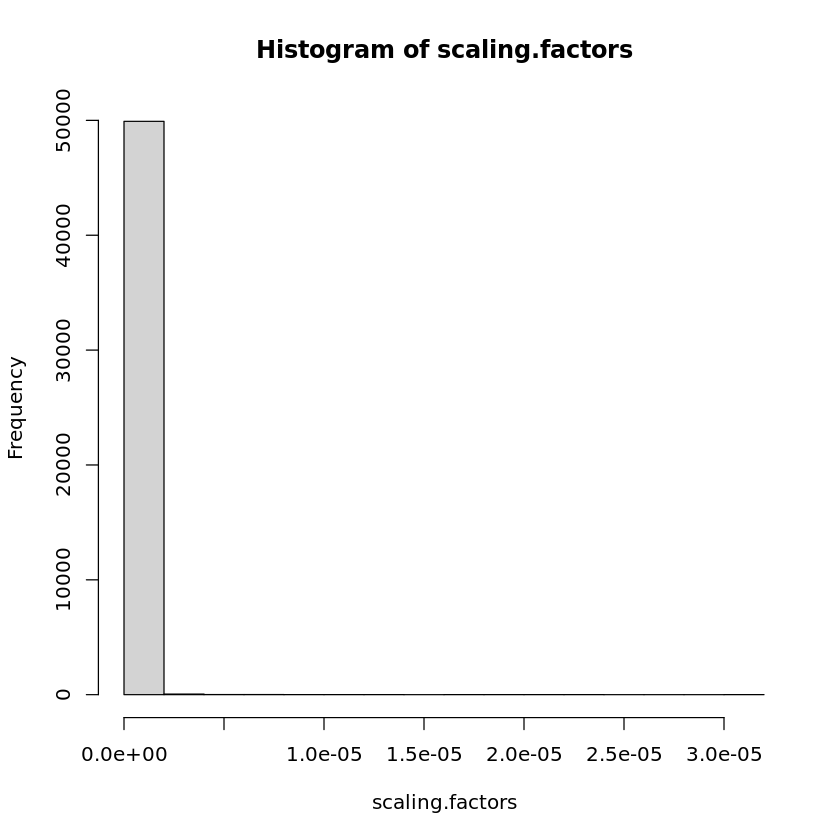

In [141]:
hist(scaling.factors)

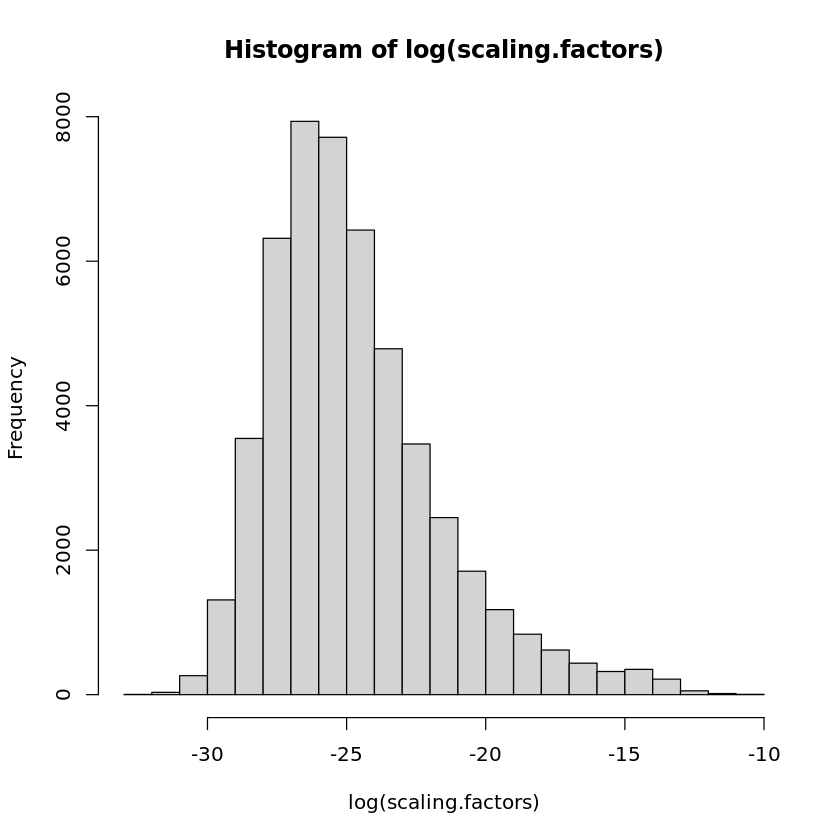

In [142]:
hist(log(scaling.factors))

In [144]:
max(log(scaling.factors))

[1] -10.3842

In [148]:
exp(100)

[1] 2.688117e+43

In [75]:
sum(is.na(log(scaling.factors)))

[1] 0

In [76]:
length(scaling.factors)

[1] 50000

In [146]:
ml.list <- list()

for (gene in guides.metadata$target.gene[1:10]) {
    print(gene)
    obs.counts <- h5read(file = fh, name = "counts", index = list(gene, 1:50000))
    gene.data <- data.frame(guide.eff = as.integer(h5read(file = fh, name = "x/x1", index = list(gene, 1:50000))),
                       s.score = cell.cycle.scores$s.scores,
                       g2m.score = cell.cycle.scores$g2m.scores,
                       counts = as.integer(obs.counts),
                       scaling.factors = scaling.factors)
    ml <- glm.nb(counts ~ guide.eff + s.score + g2m.score + offset(log(scaling.factors)), data = gene.data)
    ml.list[[gene]] <- ml
}

[1] 3683


ERROR: Error in glm.fitter(x = X, y = Y, w = w, etastart = eta, offset = offset, : NA/NaN/Inf in 'x'


In [54]:
summary(ml.list[[3683]])


Call:
glm.nb(formula = counts ~ guide.eff, data = gene.data, init.theta = 0.05211118873, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8130  -0.8130  -0.8130  -0.4996  30.4046  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.38511    0.01965  172.27   <2e-16 ***
guide.eff   -3.20122    0.30722  -10.42   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.0521) family taken to be 1)

    Null deviance: 29512  on 49999  degrees of freedom
Residual deviance: 29463  on 49998  degrees of freedom
AIC: 172119

Number of Fisher Scoring iterations: 1


              Theta:  0.052111 
          Std. Err.:  0.000467 

 2 x log-likelihood:  -172112.870000 

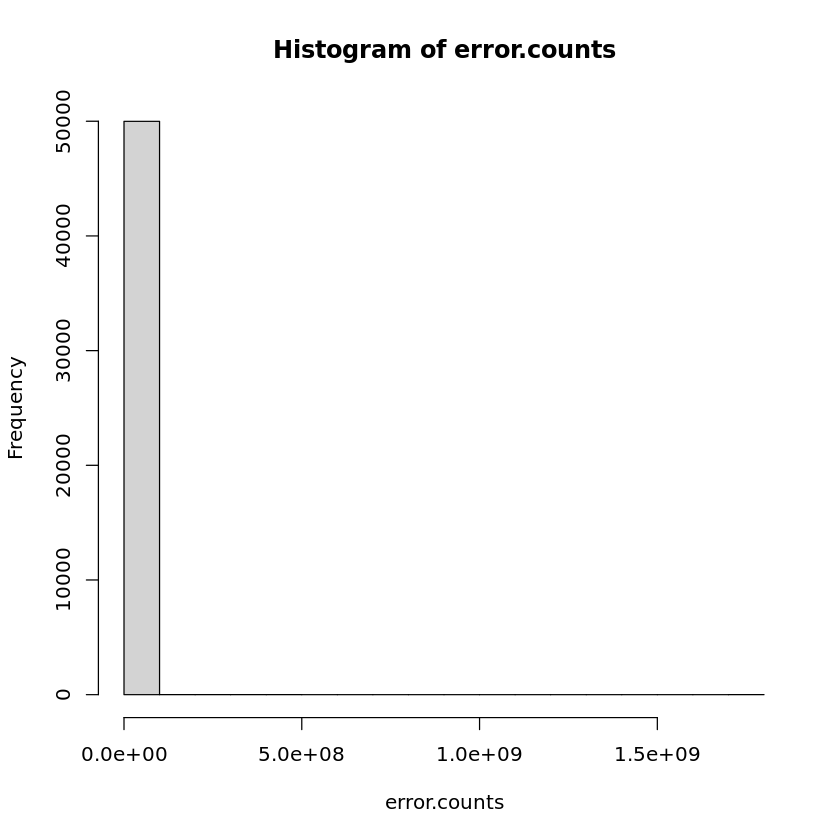

In [22]:
error.counts <- h5read(file = fh, name = "counts", index = list(11331, 1:50000))
max(error.counts)

In [33]:
max(error.counts)

[1] 1760440863

In [92]:
test.df <- data.frame(cbind(counts.matrix[3683, ], scaling.factors))
colnames(test.df) <- c('count', 'scaling.factor')
head(test.df)

,count,scaling.factor
,<dbl>,<dbl>
1,0,0.444139
2,1,3.763414
3,0,0.056302
4,0,0.009779
5,0,0.106756
6,0,0.024059


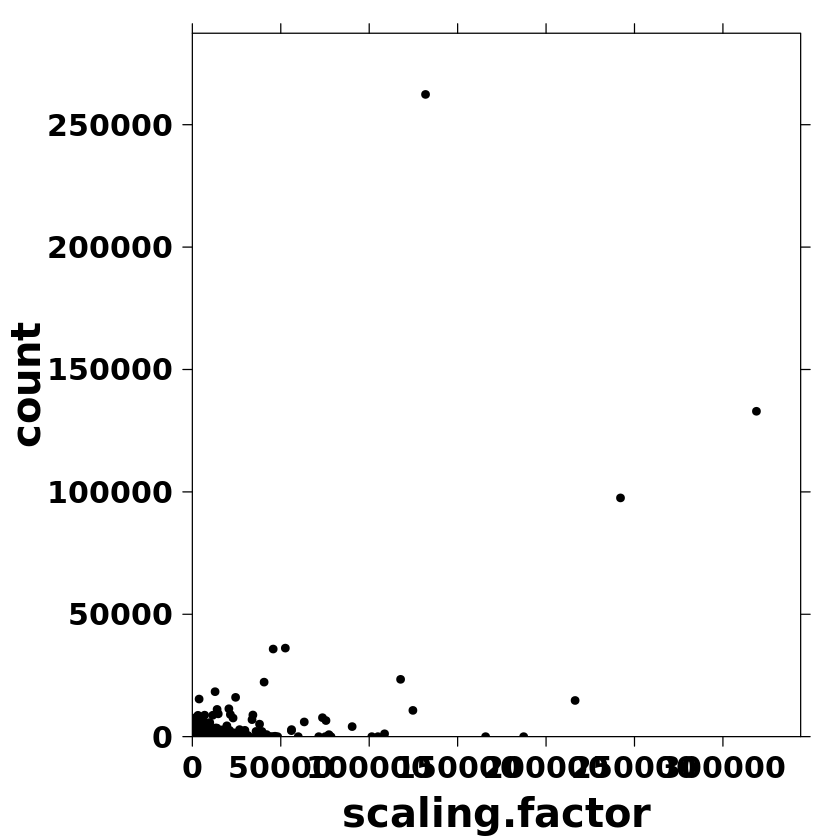

In [94]:
create.scatterplot(
    formula = count ~ scaling.factor,
    data = test.df,
)

In [101]:
log(max(scaling.factors))

[1] 12.67279

In [87]:
nrow(counts.matrix)

[1] 13000

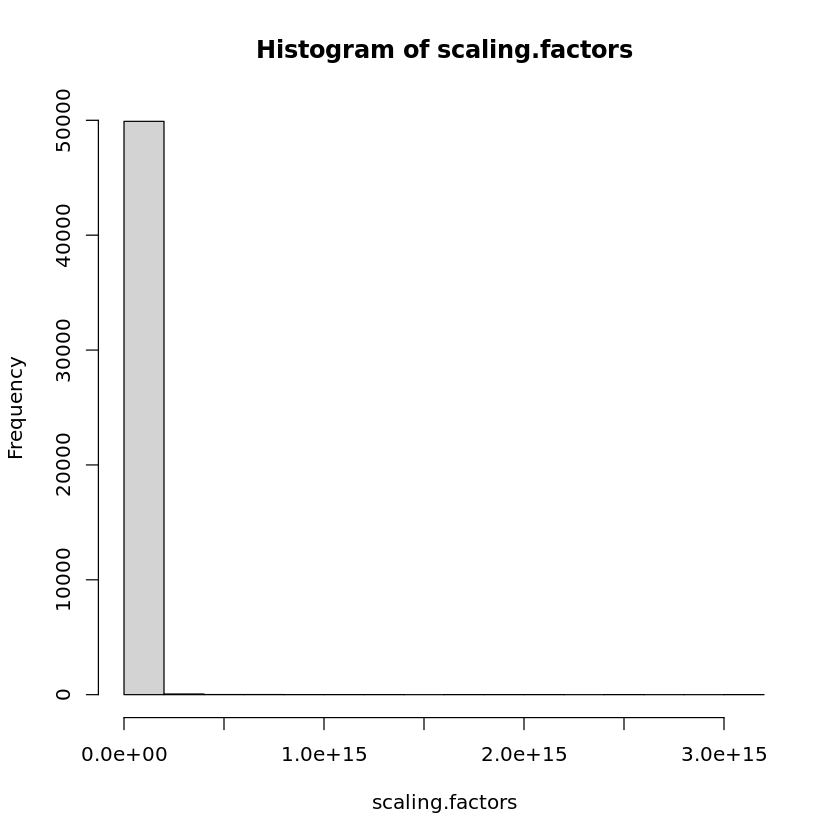

In [114]:
hist(scaling.factors)